In [ ]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip


--2022-08-15 04:39:21--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.4
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip’

driver_drowsiness_d 100%[===================>] 121.53M  11.5MB/s    in 13s     

2022-08-15 04:39:35 (9.61 MB/s) - ‘driver_drowsiness_detection_modified.zip’ saved [127436131/127436131]



In [ ]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


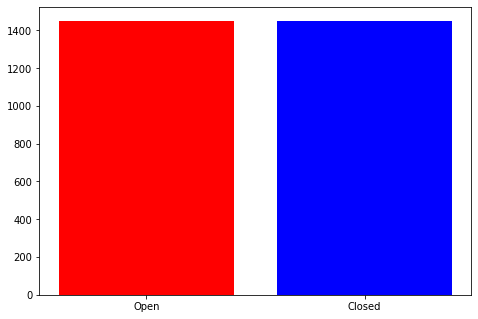

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Open', 'Closed']
y= [len(X),len(Y)]
ax.bar(x,y,color=['red','blue'])
plt.show()

In [ ]:
sfor i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)


1452
(32, 32, 3)


In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [ ]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


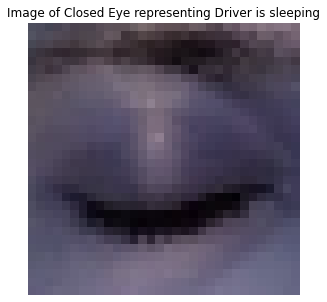

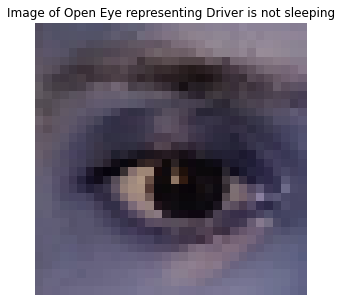

In [ ]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


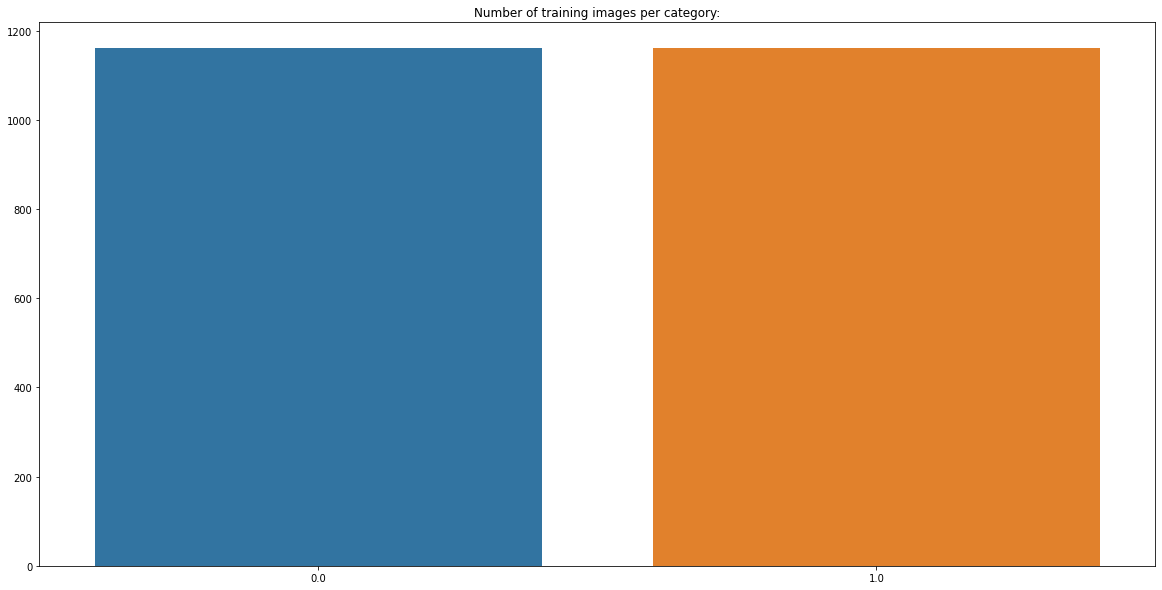

In [ ]:
unique_train, count = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_train, count).set_title("Number of training images per category:")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


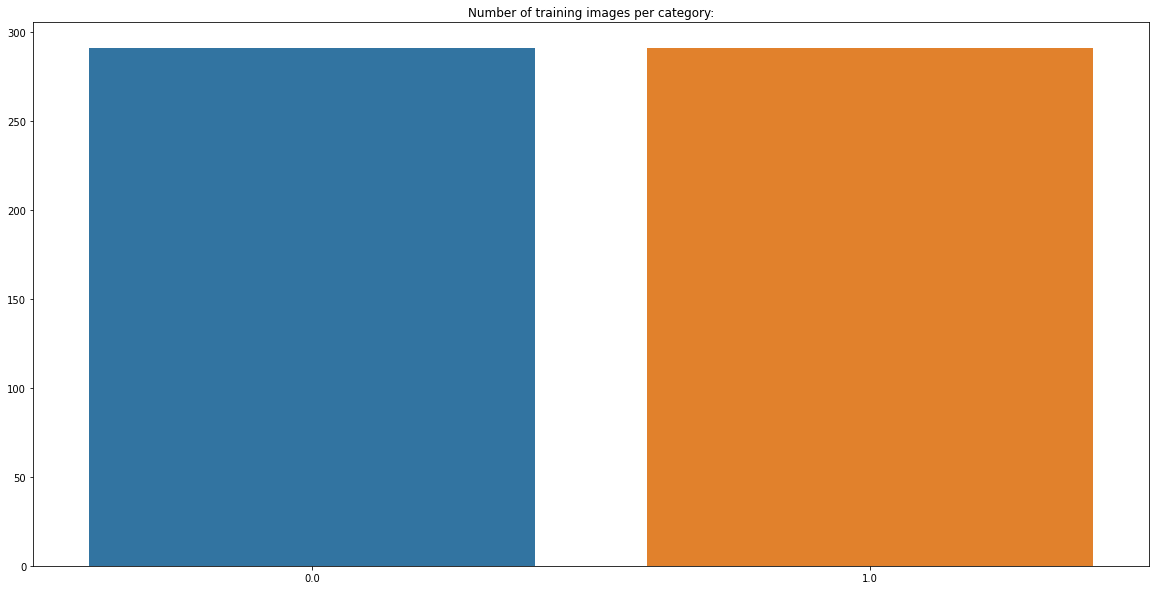

In [ ]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_test, count_test).set_title("Number of training images per category:")
plt.show()


In [ ]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
10/10 [==============================] - 9s 757ms/step - loss: 1.3901 - accuracy: 0.5263 - val_loss: 0.6936 - val_accuracy: 0.4914
Epoch 2/100
10/10 [==============================] - 7s 694ms/step - loss: 1.1980 - accuracy: 0.5375 - val_loss: 0.6924 - val_accuracy: 0.4983
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 1.1507 - accuracy: 0.5495 - val_loss: 0.6886 - val_accuracy: 0.5120
Epoch 4/100
10/10 [==============================] - 7s 693ms/step - loss: 1.0099 - accuracy: 0.5805 - val_loss: 0.6754 - val_accuracy: 0.5326
Epoch 5/100
10/10 [==============================] - 7s 689ms/step - loss: 0.9016 - accuracy: 0.6072 - val_loss: 0.6605 - val_accuracy: 0.6357
Epoch 6/100
10/10 [==============================] - 8s 821ms/step - loss: 0.8342 - accuracy: 0.6176 - val_loss: 0.6477 - val_accuracy: 0.7045
Epoch 7/100
10/10 [==============================] - 7s 689ms/step - loss: 0.8161 - accuracy: 0.6417 - val_loss: 0.6385 - val_accuracy: 0.7388
E

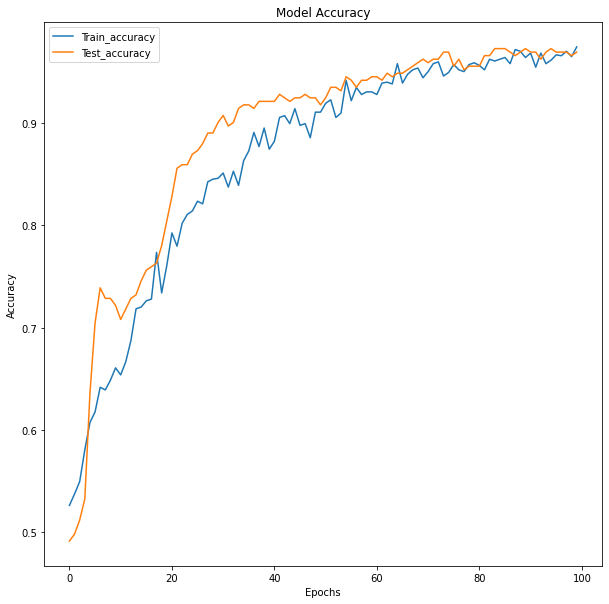

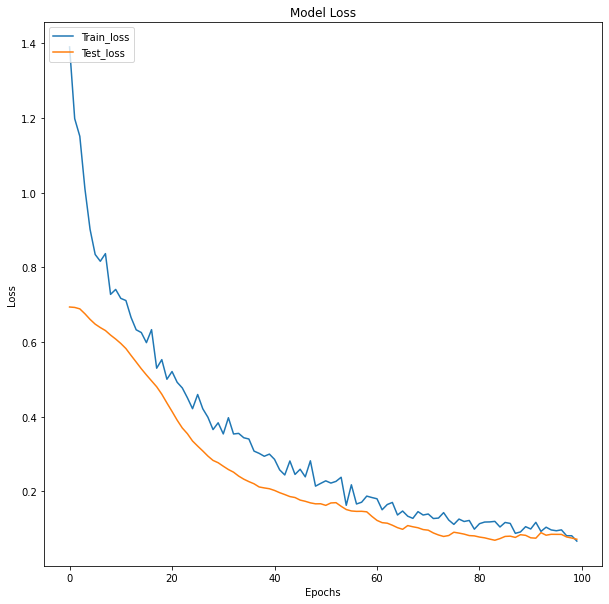

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 1s 69ms/step - loss: 0.0716 - accuracy: 0.9691
Test Set Accuracy: 0.969072163105011
Test Set Loss: 0.07161762565374374


In [ ]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       149
           1       0.96      0.98      0.97       142

    accuracy                           0.97       291
   macro avg       0.97      0.97      0.97       291
weighted avg       0.97      0.97      0.97       291



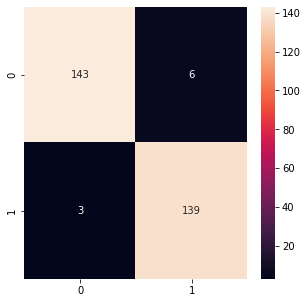

In [ ]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [ ]:
model.save('Driver_Drowsiness_Detection.h5')

In [ ]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [ ]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

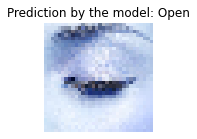

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

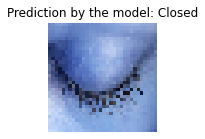

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()


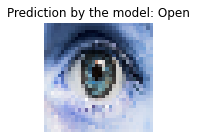

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

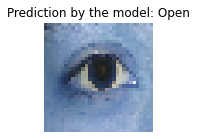

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

In [ ]:
def full_face_detection_pipeline(input_image_path):
    face_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_eye.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('driver_drowsiness_detection/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        #cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []
        #[int(x) for x in eyesCenter]
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
            #cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Not Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = 'driver_drowsiness_detection/test_image_prediction.jpg'
    cv2.imwrite(output_path, test_image) 
    return output_path

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


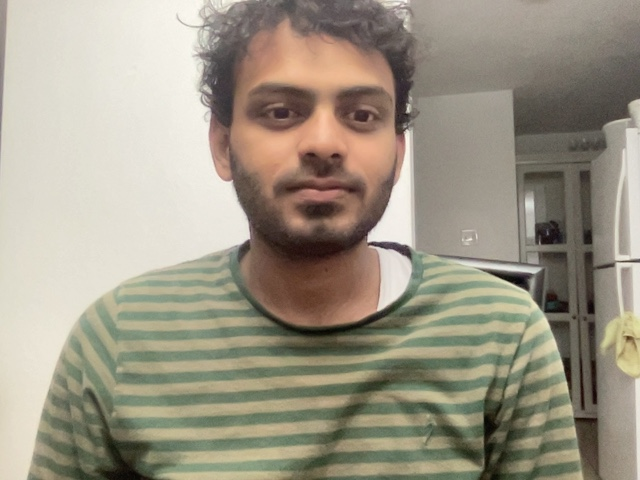

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

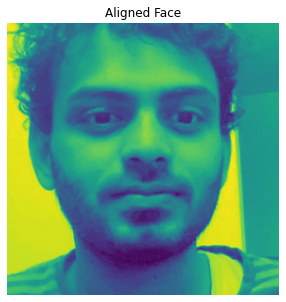

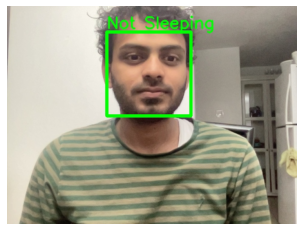

In [ ]:
figure = plt.figure(figsize=(5, 5))
#draw_box_3d('photo.jpg', )
predicted_image = cv2.imread(full_face_detection_pipeline('photo.jpg'))
#draw_box_3d('photo.jpg')
#predicted_image=cv2.circle(img,(int(pts1[1][0]),int(pts1[1][1])),5,(0,0,255),cv.FILLED)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off') 
plt.show()

<IPython.core.display.Javascript object>

Saved to photo.jpg


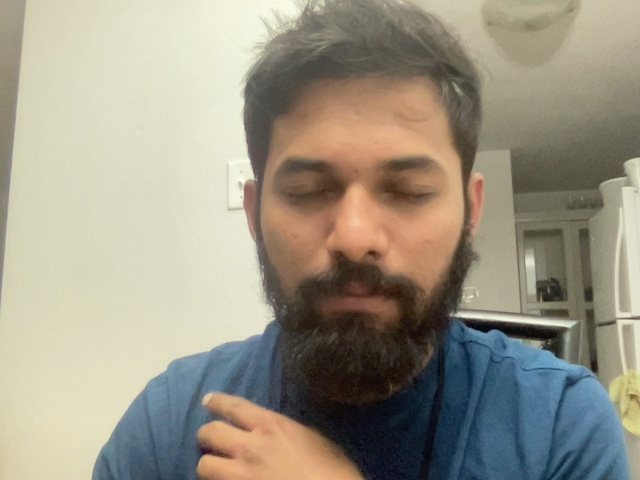

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

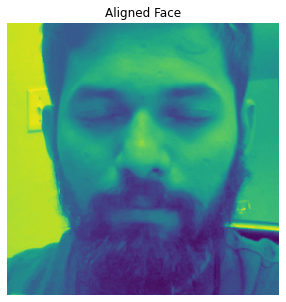

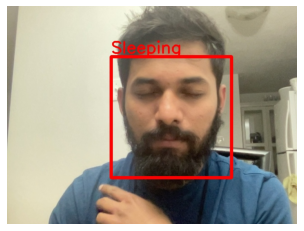

In [ ]:
figure = plt.figure(figsize=(5, 5))
#draw_box_3d('photo.jpg', )
predicted_image = cv2.imread(full_face_detection_pipeline('photo.jpg'))
#draw_box_3d('photo.jpg')
#predicted_image=cv2.circle(img,(int(pts1[1][0]),int(pts1[1][1])),5,(0,0,255),cv.FILLED)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off') 
plt.show()